# Expressibility and engtangling capability

In [1]:
import warnings
import json
import os
import sys
import glob
import numpy
import pickle
import random
import collections
import pennylane as qml
import matplotlib.pyplot as plt

from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
from utils import transform_into_pennylane_circuits, read_diagrams, get_symbols

this_folder = os.path.abspath(os.getcwd())
nshot = 1000

In [2]:
num_of_bins = 75
bins_list = [i/(num_of_bins) for i in range(num_of_bins + 1)]
bins_x = [bins_list[1]+bins_list[i] for i in range(num_of_bins - 1)]

def P_harr(l, u, N):
    return (1-l)**(N-1)-(1-u)**(N-1)

#Harr histogram
P_harr_hist = [P_harr(bins_list[i], bins_list[i+1], 2) for i in range(num_of_bins)]

In [3]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//"\
            + workload + "//" + workload_size + "//circuits//"\
            + str(classification) + "//" + str(layers) + "_layer//"\
           + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count)\
            + "_n_wire_count//"

In [4]:
training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [5]:
training_circuits = read_diagrams(training_circuits_paths)
#validation_circuits = read_diagrams(validation_circuits_paths)
#test_circuits = read_diagrams(test_circuits_paths)

In [6]:
n_qubits = 20
dev = qml.device("default.qubit", wires=n_qubits, shots=nshot)

qml_training_circuits, train_symbols = transform_into_pennylane_circuits(training_circuits, n_qubits, dev)
#qml_test_circuits, test_symbols = transform_into_pennylane_circuits(test_circuits.values(), n_qubits, dev)
#qml_validation_circuits, val_symbols = transform_into_pennylane_circuits(validation_circuits.values(), n_qubits, dev)
qml_circuits = qml_training_circuits #+ qml_test_circuits + qml_validation_circuits

## Expressibility

In [7]:
def post_select_circuit_samples(circuit_samples, n_qubits):
    selected_samples = []
    post_select_array = np.array([0]*(n_qubits - 1))
    for circuit_sample in circuit_samples:
        if np.array_equal(circuit_sample[1:n_qubits], post_select_array):
            #print(circuit_sample[1:n_qubits], post_select_array)
            if circuit_sample[0] == 1:
                selected_samples.append(1)
            else:
                selected_samples.append(0)
    return selected_samples

In [8]:
fidelity=[]
for i, c in enumerate(qml_circuits):
    print("Progress:", i/len(qml_circuits))
    circuit = qml_circuits[c]["qml_circuit"]
    n_qubits = qml_circuits[c]["n_qubits"]
    symbols = train_symbols

    for x in range(1000):
        params = [2*np.pi*random.uniform(0, 1) for i in range(len(symbols))]
        result = circuit(params)
        post_selected_result = post_select_circuit_samples(result, n_qubits)
        res = collections.Counter(post_selected_result)

        if 0 in res:
            ratio = res[0]/nshot
        else:
            ratio = 0

        fidelity.append(ratio)

Progress: 0.0


Progress: 0.002232142857142857
Progress: 0.004464285714285714
Progress: 0.006696428571428571
Progress: 0.008928571428571428
Progress: 0.011160714285714286
Progress: 0.013392857142857142
Progress: 0.015625
Progress: 0.017857142857142856
Progress: 0.020089285714285716
Progress: 0.022321428571428572
Progress: 0.024553571428571428
Progress: 0.026785714285714284
Progress: 0.029017857142857144
Progress: 0.03125
Progress: 0.033482142857142856
Progress: 0.03571428571428571
Progress: 0.03794642857142857
Progress: 0.04017857142857143
Progress: 0.04241071428571429
Progress: 0.044642857142857144
Progress: 0.046875
Progress: 0.049107142857142856
Progress: 0.05133928571428571
Progress: 0.05357142857142857
Progress: 0.05580357142857143
Progress: 0.05803571428571429
Progress: 0.060267857142857144
Progress: 0.0625
Progress: 0.06473214285714286
Progress: 0.06696428571428571
Progress: 0.06919642857142858
Progress: 0.07142857142857142
Progress: 0.07366071428571429
Progress: 0.07589285714285714
Progress: 0

Progress: 0.6540178571428571
Progress: 0.65625
Progress: 0.6584821428571429
Progress: 0.6607142857142857
Progress: 0.6629464285714286
Progress: 0.6651785714285714
Progress: 0.6674107142857143
Progress: 0.6696428571428571
Progress: 0.671875
Progress: 0.6741071428571429
Progress: 0.6763392857142857
Progress: 0.6785714285714286
Progress: 0.6808035714285714
Progress: 0.6830357142857143
Progress: 0.6852678571428571
Progress: 0.6875
Progress: 0.6897321428571429
Progress: 0.6919642857142857
Progress: 0.6941964285714286
Progress: 0.6964285714285714
Progress: 0.6986607142857143
Progress: 0.7008928571428571
Progress: 0.703125
Progress: 0.7053571428571429
Progress: 0.7075892857142857
Progress: 0.7098214285714286
Progress: 0.7120535714285714
Progress: 0.7142857142857143
Progress: 0.7165178571428571
Progress: 0.71875
Progress: 0.7209821428571429
Progress: 0.7232142857142857
Progress: 0.7254464285714286
Progress: 0.7276785714285714
Progress: 0.7299107142857143
Progress: 0.7321428571428571
Progress: 

In [9]:
#print(fidelity)

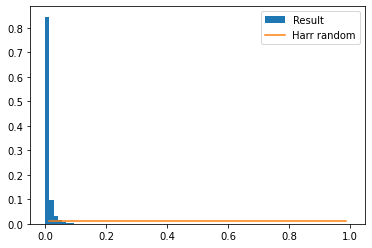

In [10]:
weights = numpy.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, label='Result', range=[0, 1])
plt.plot(bins_x, P_harr_hist[:-1], label='Harr random')
plt.legend(loc='upper right')
plt.show()

In [11]:
from scipy.special import kl_div
P_I_hist = numpy.histogram(fidelity, bins = bins_list, weights = weights, range=[0, 1])[0]
kl_pq = kl_div(P_I_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 3.713 nats


In [12]:
import pickle

with open('results//fidelity_execution_time_1_1_3_1_main.pickle', 'wb') as handle:
    pickle.dump(fidelity, handle, protocol=pickle.HIGHEST_PROTOCOL)